<a href="https://colab.research.google.com/github/Gabinson200/TinyML_UF_2023/blob/main/TFLM_speech_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a Simple Audio Recognition Model (Adam K Version)

The following code is based on the following codes:

https://www.tensorflow.org/tutorials/audio/simple_audio for the network and training data

and

https://www.tensorflow.org/lite/models/convert for network conversion

## Data importing, exploration, and pre-processing

In [1]:
#Get the big dataset
!pip install -U -q tensorflow tensorflow_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.4 MB/s eta 0:00:00


In [2]:
#Importing libraries
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### Load in the dataset and perform data augmentation

The dataset's audio clips are stored in eight folders corresponding to each speech command: no, yes, down, go, left, up, right, and stop. The audio clips are 1 second or less at 16kHz. The output_sequence_length=16000 pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [3]:
#This just gets the dataset from tensorflow
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 1s 0us/step


In the cell below we choose two wakewords that we want to train the network on
you can choose any words in the dataset of your choosing I choose yes and no

In [4]:
new_folder_path = '/content/yn_data' #rename to wanted destination
os.makedirs(new_folder_path, exist_ok=True)

import shutil

source_folder1 = '/content/data/mini_speech_commands/yes' #rename if needed to folders you want indluded
source_folder2 = '/content/data/mini_speech_commands/no'  #rename if needed to folders you want indluded
destination_folder = new_folder_path

shutil.move(source_folder1, destination_folder)
shutil.move(source_folder2, destination_folder)

'/content/yn_data/no'

In [5]:
NEW_DATASET_PATH = 'yn_data' #rename to what you called your destination folder
data_dir = pathlib.Path(NEW_DATASET_PATH)

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['no' 'yes']


In [6]:
#split to train and validation dataset using the funky audio_dataset_from_directory function
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Using 400 files for validation.

label names: ['no' 'yes']


In [7]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [8]:
#only single channel audio in this data and this function removes the additional axis
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [9]:
#Get test dataset from validation dataset
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [11]:
#This is just needed for the graphing below
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


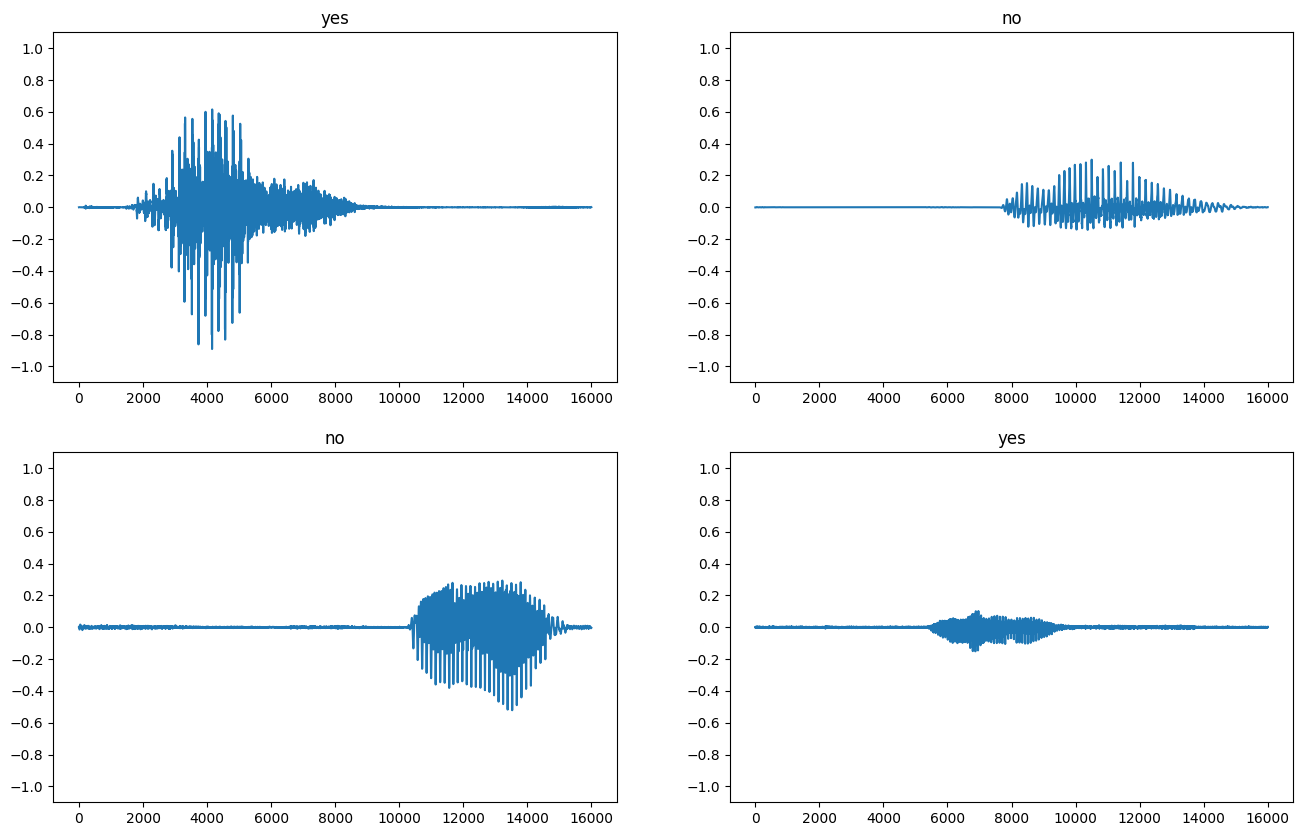

In [12]:
#Plot some of the audio samples
plt.figure(figsize=(16, 10))
rows = 2
cols = 2
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [13]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram


In [14]:
#Show some of the samples
for i in range(2):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [15]:
#Function used to plot the spectograms
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


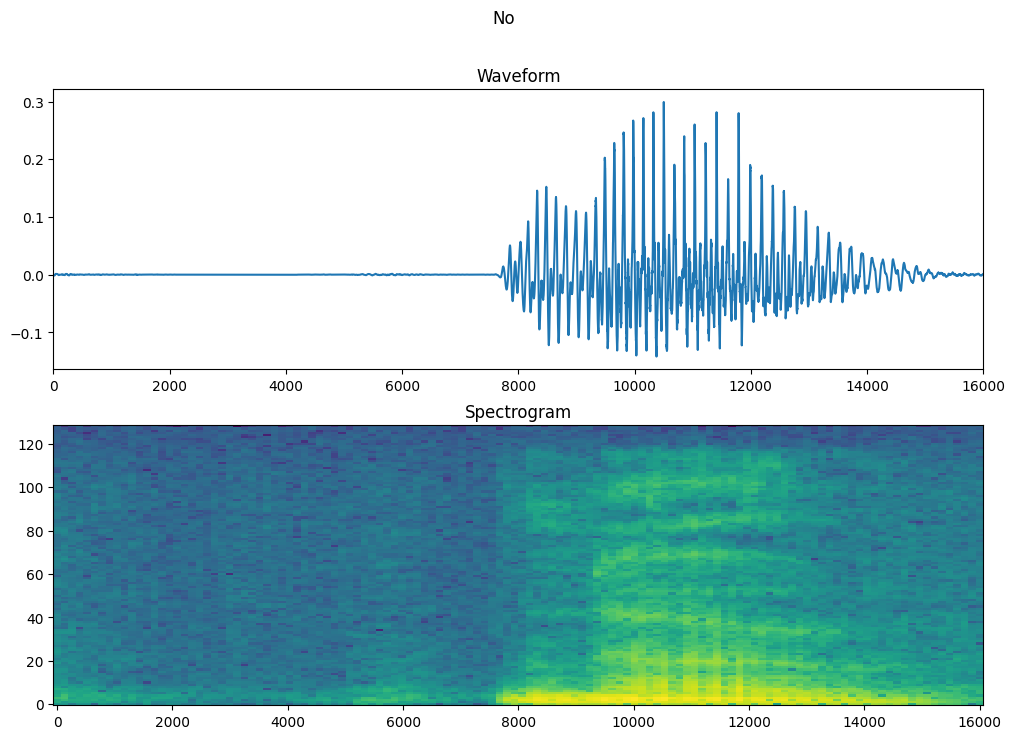

In [16]:
#Plot waveform and spectogram image of calss samples
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()


In [17]:
#Function that helps us convert our data to spectograms that can be fed into CNNs
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)


In [18]:
#Convert data
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [19]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

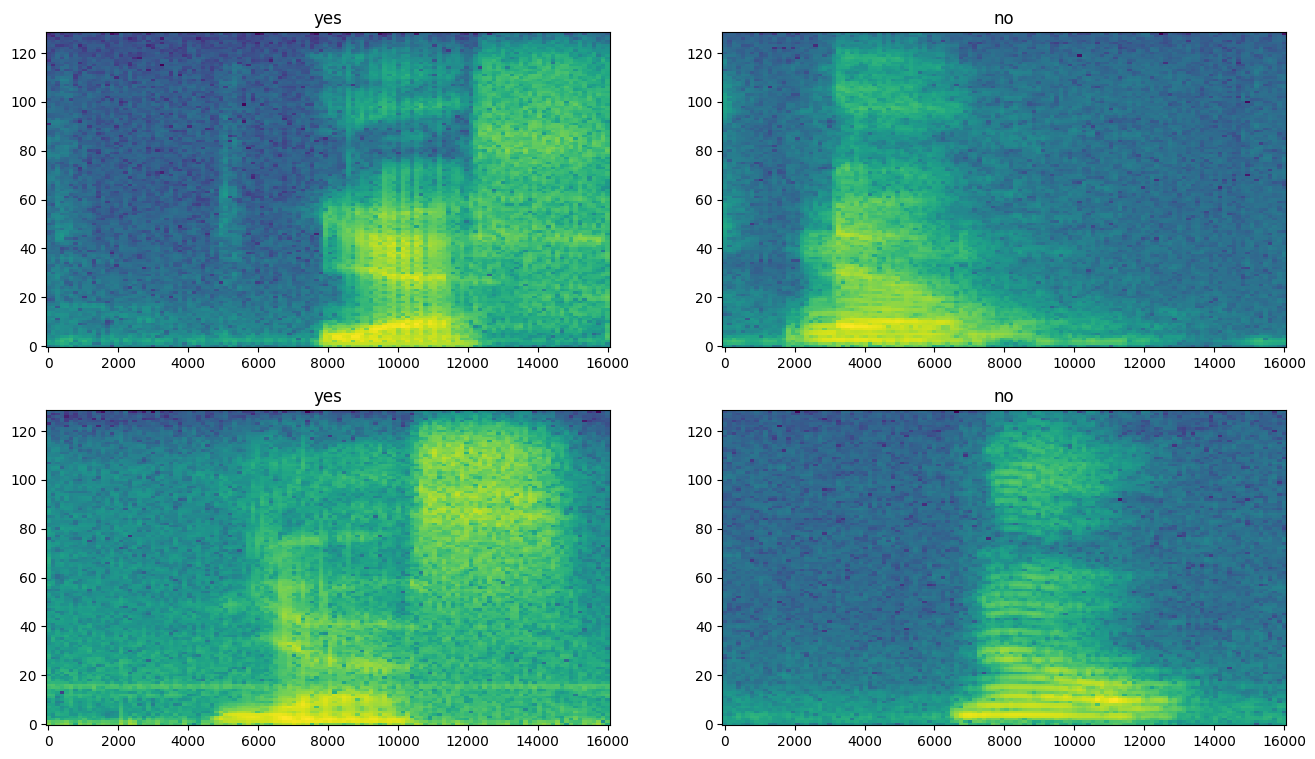

In [20]:
rows = 2
cols = 2
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(example_spectrograms[i].numpy(), ax)
  ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()


## Build and train convolutional neural network

In [21]:
#This is just here to speed up the fetching of data during training
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### Change the model architecture below and we will compare the results in colab and on the MCU

In [23]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))


#Change the following model parameters to your desire and we will try to test the different model performances on the MCU
model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

Notice the size of the model above (for me about 6.2 MB which obviously wont fit into an MCU that might have as little as 256Kb memory)

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [25]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
25/25 [==============================] - 12s 32ms/step - loss: 0.4270 - accuracy: 0.8056 - val_loss: 0.3535 - val_accuracy: 0.8229
Epoch 2/10
25/25 [==============================] - 0s 9ms/step - loss: 0.2546 - accuracy: 0.8944 - val_loss: 0.2458 - val_accuracy: 0.9010
Epoch 3/10
25/25 [==============================] - 0s 9ms/step - loss: 0.1849 - accuracy: 0.9300 - val_loss: 0.1836 - val_accuracy: 0.9375
Epoch 4/10
25/25 [==============================] - 0s 8ms/step - loss: 0.1489 - accuracy: 0.9388 - val_loss: 0.1684 - val_accuracy: 0.9427
Epoch 5/10
25/25 [==============================] - 0s 8ms/step - loss: 0.1346 - accuracy: 0.9500 - val_loss: 0.1496 - val_accuracy: 0.9531
Epoch 6/10
25/25 [==============================] - 0s 9ms/step - loss: 0.0921 - accuracy: 0.9688 - val_loss: 0.1728 - val_accuracy: 0.9427
Epoch 7/10
25/25 [==============================] - 0s 9ms/step - loss: 0.0848 - accuracy: 0.9675 - val_loss: 0.1569 - val_accuracy: 0.9583
Epoch 7: early sto

Text(0, 0.5, 'Accuracy [%]')

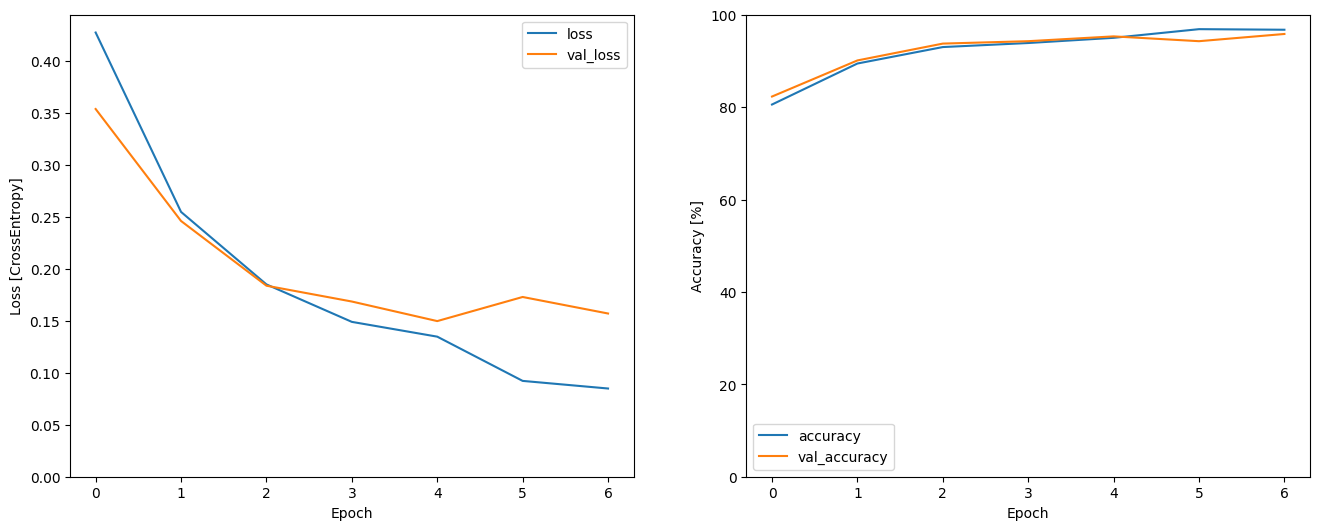

In [26]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [27]:
model.evaluate(test_spectrogram_ds, return_dict=True)

4/4 [==============================] - 0s 92ms/step - loss: 0.2079 - accuracy: 0.9519


{'loss': 0.2079193890094757, 'accuracy': 0.9519230723381042}

### Test the model with use data

In [28]:

#Inlcude necesarry liraries
!pip install ffmpeg-python &> 0       # &> shell command to hide output
!pip install tensorflow-io &> 0
!pip install python_speech_features &> 0
print("Packages Installed")

from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import tensorflow_io as tfio
import matplotlib.pyplot as plt
from python_speech_features import mfcc
from matplotlib import cm
import pickle
import librosa
print("Packages Imported")

Packages Installed
Packages Imported


In [29]:
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.core.display import display, HTML
from IPython.display import Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [30]:
audio_yes_loud, sr_yes_loud = get_audio()
print("DONE")

DONE


In [31]:
# audio_yes_quiet, sr_yes_quiet = get_audio()
# print("DONE")

In [32]:
# audio_no_loud, sr_no_loud = get_audio()
# print("DONE")

In [33]:
# audio_no_quiet, sr_no_quiet = get_audio()
# print("DONE")

### Saving custom audio files

If you would like to save your files for later, uncomment and run the lines of code in the below cell. you can find your files in the folder icon to the left (left tab).

In [34]:
# audio_files = {
#   'audio_yes_loud': audio_yes_loud, 'sr_yes_loud': sr_yes_loud,
#   'audio_yes_quiet': audio_yes_quiet, 'sr_yes_quiet': sr_yes_quiet,
#   'audio_no_loud': audio_no_loud, 'sr_no_loud': sr_no_loud,
#   'audio_no_quiet': audio_no_quiet, 'sr_no_quiet': sr_no_quiet,
# }
# with open('audio_files.pkl', 'wb') as fid:            ##  store python object
#   pickle.dump(audio_files, fid)

### Inspect audio sample

In [35]:
print("audio_yes_loud:", audio_yes_loud)
print("type:", type(audio_yes_loud))
print("shape:", audio_yes_loud.shape)
print(sr_yes_loud)

audio_yes_loud: [[0 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]
type: <class 'numpy.ndarray'>
shape: (100352, 2)
48000


### Listen to User Audio Samples

In [36]:
Audio(audio_yes_loud[:,0], rate=sr_yes_loud)

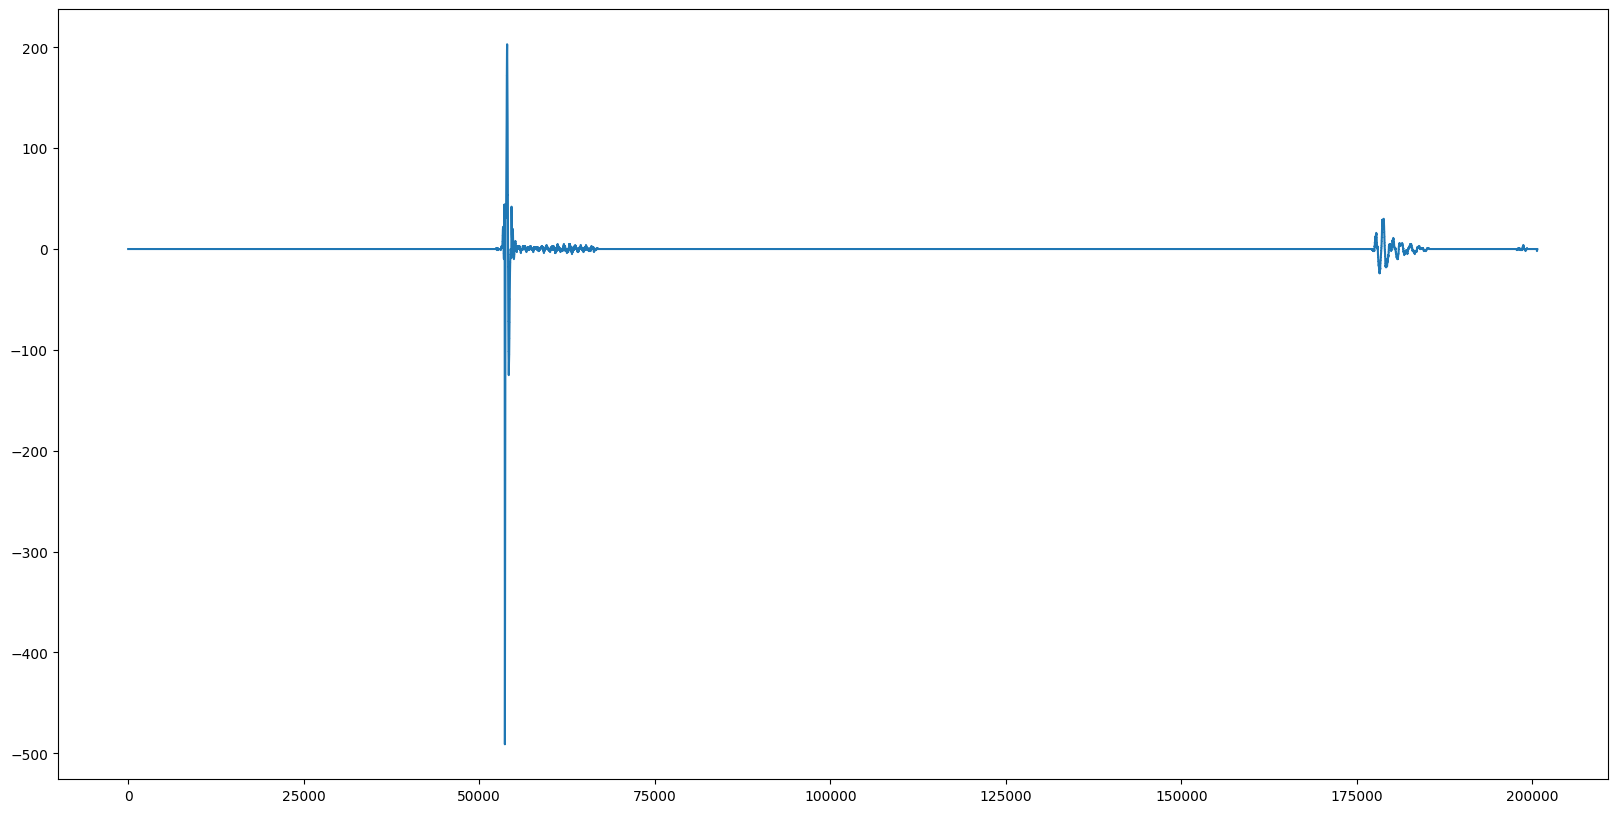

In [37]:
audio_yes_loud_f = audio_yes_loud.flatten()
plt.figure(figsize=(20,10))
plt.plot(audio_yes_loud_f)
plt.show()

In [38]:
waveform = audio_yes_loud_f
x = get_spectrogram(audio_yes_loud_f.astype(float))
x = x[tf.newaxis,...]
reshaped_input = x[:, :124, :, :]

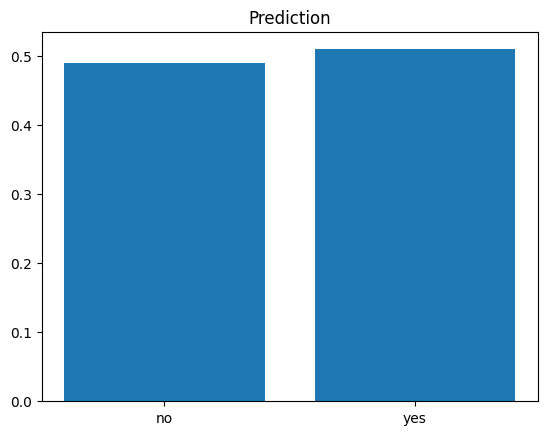

In [39]:
prediction = model(reshaped_input)
x_labels = ['no', 'yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Prediction')
plt.show()


### Export Model

In [40]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}


In [41]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 1.1426687, -2.3624053]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

In [42]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")

# Part 2 Shrinking the Model and getting it ready for uploading into MCU

#### Integer only quantization (This type of quantization is needed for edge devices)
https://www.tensorflow.org/lite/performance/post_training_integer_quant

In [43]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(example_spectrograms).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [44]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


### Save the Model

In [45]:
#Save the quantize model
import pathlib

tflite_models_dir = pathlib.Path("/content")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"aww_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)


1632152

### Run the quantized model

In [46]:
imgs = []
labels = []
for element in train_spectrogram_ds:
    img, label = element
    imgs.append(img)
    labels.append(label)

imgs = np.array(imgs)
labels = np.array(labels)


# Reshape the arrays
imgs = imgs.reshape(-1, 124, 129, 1)
labels = labels.reshape(-1)

# Print the reshaped arrays' shapes
print("Reshaped Array 1 Shape:", imgs.shape)
print("Reshaped Array 2 Shape:", labels.shape)

Reshaped Array 1 Shape: (1600, 124, 129, 1)
Reshaped Array 2 Shape: (1600,)


In [47]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices, test_images, test_labels):

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions


In [48]:
# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type, test_labels):

  predictions = run_tflite_model(tflite_file, [test_image_index], imgs, labels)

  plt.imshow(imgs[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)


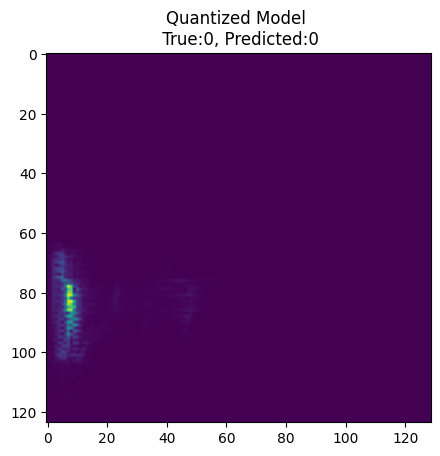

In [49]:
test_model(tflite_model_quant_file, test_image_index, "Quantized", labels)

In [50]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type, test_images, test_labels):

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices, imgs, labels)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))


In [51]:
evaluate_model(tflite_model_quant_file, "Quantized", imgs, labels)

Quantized model accuracy is 96.5000% (Number of test samples=1600)


In [53]:
#Model quantized analysis
tf.lite.experimental.Analyzer.analyze(model_content=tflite_model_quant)

=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the QUANTIZE op takes
tensor #0 as input and produces tensor #11 as output.

Subgraph#0 main(T#0) -> [T#19]
  Op#0 QUANTIZE(T#0) -> [T#11]
  Op#1 RESIZE_BILINEAR(T#11, T#1[32, 32]) -> [T#12]
  Op#2 CONV_2D(T#12, T#10, T#9[55, 21, 20, 100, 70, ...]) -> [T#13]
  Op#3 CONV_2D(T#13, T#8, T#7[530, 430, 686, 130, 504, ...]) -> [T#14]
  Op#4 MAX_POOL_2D(T#14) -> [T#15]
  Op#5 RESHAPE(T#15, T#2[-1, 12544]) -> [T#16]
  Op#6 FULLY_CONNECTED(T#16, T#6, T#5[68, 275, 614, 406, 785, ...]) -> [T#17]
  Op#7 FULLY_CONNECTED(T#17, T#4, T#3[87, -87]) -> [T#18]
  Op#8 QUANTIZE(T#18) -> [T#19]

Tensors of Subgraph#0
  T#0(serving_default_input_1:0) shape_signature:[-1, 124, 129, 1], type:UINT8
  T#1(sequential/resizing/resize/size) shape:[2], type:INT32 RO 8 bytes, buffer: 2, data:[32, 32]
  T#2(sequential/flatten/Const) shape:[2], type:INT32 

Nice! It looks liek we got the model size down to 1.6 Mb which would now fit into our MCU but still a far cry from the 20Kb minimum achieved in the documentation
https://github.com/tensorflow/tflite-micro/tree/main/tensorflow/lite/micro/examples/micro_speech/train

**If you want to go back to the model creation and copy or alter their model to your liking and see how it performs and affects the model size after quantization**

###Further Quantization Info
additional quant info
https://www.tensorflow.org/lite/performance/quantization_spec

if your quantized model has low accuracy look into
https://www.tensorflow.org/lite/performance/quantization_debugger

# Part 2 Uploading and Running on MCU

This notebook is getting a bit too long and so additional code for uploading the model to the mcu will be done elsewhere.

https://www.tensorflow.org/lite/microcontrollers

## Nonetheless lets convert our model to a cc file that we can use in our MCU IDE of choice

We need to run a command in unix so run the following cells and type in the text to the terminal then download the cc file to your machine

https://www.tensorflow.org/lite/microcontrollers/build_convert


In [56]:
!pip install colab-xterm
%load_ext colabxterm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 1.3 MB/s eta 0:00:00


In [57]:
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

In [58]:
# xxd -i aww_model_quant.tflite > model_data.cc